# **CPSC392 Final Project Code**

### Emily Nguyen



---



####**Data Dictionary for Variables Used:**

- `brand_name`: full name of the product brand
- `loves_count`: number of people who have marked this product as a favorite
- `rating`: average rating (1-5) of the product based on user reviews
- `reviews`: number of user reviews for the product
- `size`: size of the product, which may be in oz, ml, g, packs, or other units depending on the product type
- `price_usd`: price of the product in US dollars
- `limited_edition`: indicates whether the product is a limited edition or not (1-true, 0-false)
- `online_only`: indicates whether the product is only sold online or not (1-true, 0-false)
- `out_of_stock`: indicates whether the product is currently out of stock or not (1 if true, 0 if false)
- `sephora_exclusive`: indicates whether the product is exclusive to Sephora or not (1 if true, 0 if false)

#### **Import packages and load data**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# data imports
import pandas as pd
import numpy as np
from tabulate import tabulate

# modeling imports
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# performance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix,\
  f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score

# visualizations
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import seaborn as sns

# others
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

%matplotlib inline

####**Load Dataset**

In [ ]:
# load dataset
sephora_original = pd.read_csv("https://raw.githubusercontent.com/emilynguyenl/Sephora-Data-Analysis/main/product_info.csv")

sephora_original.shape

(8494, 27)

In [ ]:
# create a new dataset with relevant columns (columns used in the models)
sephora = pd.DataFrame(sephora_original)

sephora = sephora_original[['brand_name','loves_count','rating','reviews','size','price_usd',
                           'limited_edition','online_only','out_of_stock','sephora_exclusive']]

# display first 3 rows
sephora.head(3)

,brand_name,loves_count,rating,reviews,size,price_usd,limited_edition,online_only,out_of_stock,sephora_exclusive
0,19-69,6320,3.6364,11.0,NaN,35.0,0,1,0,0
1,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,195.0,0,1,0,0
2,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,195.0,0,1,0,0


####**Drop missing values**

In [ ]:
# drop rows with missing values
sephora.dropna(inplace=True)

# reset the index
sephora.reset_index(inplace=True)

# print out number of rows and columns
sephora.shape

(6695, 12)



---



## **Question 1:**

### When predicting whether a product is out of stock or not, which model (Logistic Regression or Gradient Boosting Tree) is better at determining stock availability?

####**Look at the distribution of binary values for the feature variable**

In [ ]:
# grab the count of values for each unique value (0 or 1)
sephora['out_of_stock'].value_counts()

0    6306
1     389
Name: out_of_stock, dtype: int64

Note: This is an imbalanced dataset

###**Logistic Regression Model**

In [ ]:
predictors_lr = ['brand_name','loves_count','reviews','sephora_exclusive'] # predictor variables
contin_lr = ['loves_count','reviews','sephora_exclusive'] # continuous variables

X_lr = sephora[predictors_lr]
y_lr = sephora['out_of_stock']

# train-test-split model validation
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr,
                                                                y_lr,
                                                                test_size=0.2,
                                                                random_state=123)

# z-score
z_lr = make_column_transformer((StandardScaler(), contin_lr),
                               (OneHotEncoder(handle_unknown='ignore'),['brand_name']), # one hot encode brand_name
                                remainder = "passthrough")

lr = LogisticRegression()

pipe_lr = Pipeline([("zscore", z_lr),
                    ("logreg", lr)])

# fit
pipe_lr.fit(X_train_lr,y_train_lr)

# predict
y_pred_train_lr = pipe_lr.predict(X_train_lr)
y_pred_test_lr = pipe_lr.predict(X_test_lr)

y_pred_train_prob_lr = pipe_lr.predict_proba(X_train_lr)[:,1]
y_pred_test_prob_lr = pipe_lr.predict_proba(X_test_lr)[:,1]

# assess
print("Train Accuracy Score:   ", accuracy_score(y_train_lr, y_pred_train_lr))
print("Train Prescision:       ", precision_score(y_train_lr, y_pred_train_lr))
print("Train Recall:           ", recall_score(y_train_lr, y_pred_train_lr))
print("Train F1:               ", f1_score(y_train_lr, y_pred_train_lr))
print("Train ROC AUC:          ", roc_auc_score(y_train_lr, y_pred_train_prob_lr))

print("\nTrain Accuracy Score:   ", accuracy_score(y_test_lr, y_pred_test_lr))
print("Test Prescision:        ", precision_score(y_test_lr, y_pred_test_lr))
print("Test Recall:            ", recall_score(y_test_lr, y_pred_test_lr))
print("Test F1:                ", f1_score(y_test_lr, y_pred_test_lr))
print("Test ROC AUC:           ", roc_auc_score(y_test_lr, y_pred_test_prob_lr))

Train Accuracy Score:    0.943614637789395
Train Prescision:        0.9375
Train Recall:            0.04746835443037975
Train F1:                0.09036144578313253
Train ROC AUC:           0.8517329716696804

Train Accuracy Score:    0.9469753547423451
Test Prescision:         1.0
Test Recall:             0.0273972602739726
Test F1:                 0.05333333333333332
Test ROC AUC:            0.7558484277954511


####**Confusion Matrix on Training Set for Logistic Regression Model**

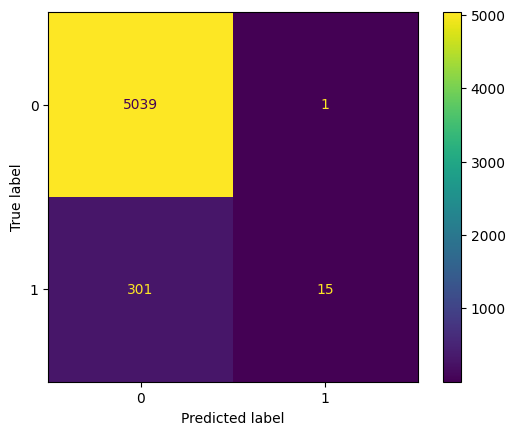

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train_lr, pipe_lr.predict(X_train_lr))

####**Confusion Matrix on Testing Set for Logistic Regression Model**

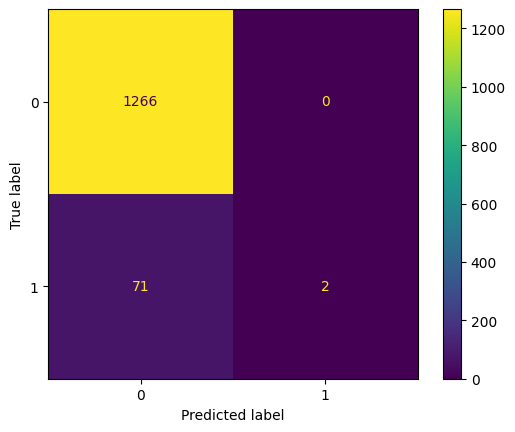

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_lr, pipe_lr.predict(X_test_lr))

####**ROC Curve Plot For Logistic Regression Model**

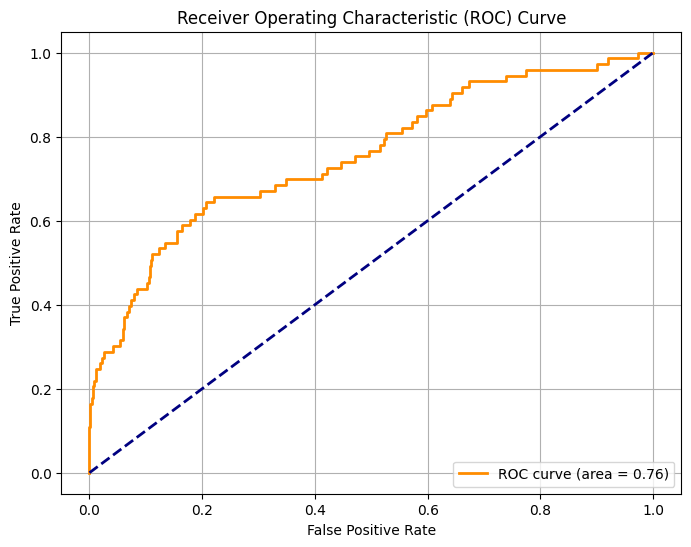

In [ ]:
# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_lr, y_pred_test_prob_lr)
roc_auc = auc(fpr, tpr)

# plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

###**Gradient Boosting Tree Regression Model**

In [ ]:
predictors_gb = ['brand_name','loves_count','reviews','sephora_exclusive'] # predictor variables
contin_gb = ['loves_count','reviews','sephora_exclusive'] # continuous variables

X_gb = sephora[predictors_gb]
y_gb = sephora['out_of_stock']

# train-test-split model validation
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb,
                                                                y_gb,
                                                                test_size=0.2,
                                                                random_state=123)

# z-score
z_gb = make_column_transformer((StandardScaler(), contin_gb),
                               (OneHotEncoder(handle_unknown='ignore'),['brand_name']), # one hot encode brand_name
                                remainder = "passthrough")

tree = GradientBoostingClassifier(random_state = 1234)

pipe_gb = Pipeline([
    ("preprocessing", z_gb),
    ("tree", tree)
])

# fit
pipe_gb.fit(X_train_gb, y_train_gb)

# predict
y_pred_train_gb = pipe_gb.predict(X_train_gb)
y_pred_test_gb = pipe_gb.predict(X_test_gb)

y_pred_train_prob_gb = pipe_gb.predict_proba(X_train_gb)[:,1]
y_pred_test_prob_gb = pipe_gb.predict_proba(X_test_gb)[:,1]

# assess
print("Train Accuracy Score:       ", accuracy_score(y_train_gb, y_pred_train_gb))
print("Train Prescision:           ", precision_score(y_train_gb, y_pred_train_gb))
print("Train Recall:               ", recall_score(y_train_gb, y_pred_train_gb))
print("Train F1:                   ", f1_score(y_train_gb, y_pred_train_gb))
print("Train ROC AUC:              ", roc_auc_score(y_train_gb, y_pred_train_prob_gb))

print("\nTest Accuracy Score:        ", accuracy_score(y_test_gb, y_pred_test_gb))
print("Test Prescision:            ", precision_score(y_test_gb, y_pred_test_gb))
print("Test Recall:                ", recall_score(y_test_gb, y_pred_test_gb))
print("Test F1:                    ", f1_score(y_test_gb, y_pred_test_gb))
print("Test ROC AUC:               ", roc_auc_score(y_test_gb, y_pred_test_prob_gb))

Train Accuracy Score:        0.9495892457057505
Train Prescision:            0.96
Train Recall:                0.1518987341772152
Train F1:                    0.26229508196721313
Train ROC AUC:               0.8270861588306209

Test Accuracy Score:         0.9469753547423451
Test Prescision:             0.5714285714285714
Test Recall:                 0.1095890410958904
Test F1:                     0.1839080459770115
Test ROC AUC:                0.7474788461122294


####**Gradient Boosting Confusion Matrix For Training Set**

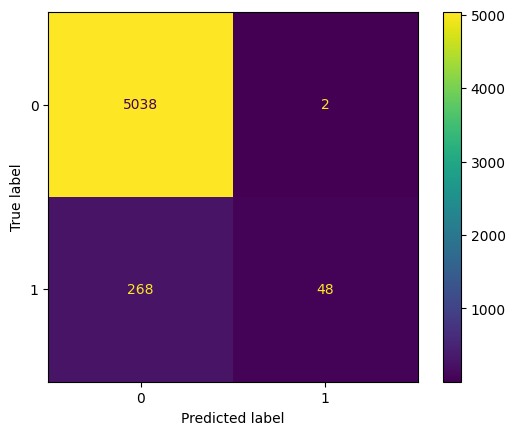

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train_gb, pipe_gb.predict(X_train_gb))

####**Gradient Boosting Confusion Matrix For Testing Set**

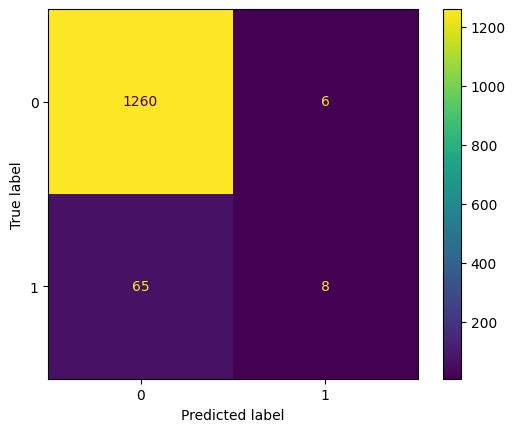

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_gb, pipe_gb.predict(X_test_gb))

####**ROC Curve Plot for Gradient Boosting Model**

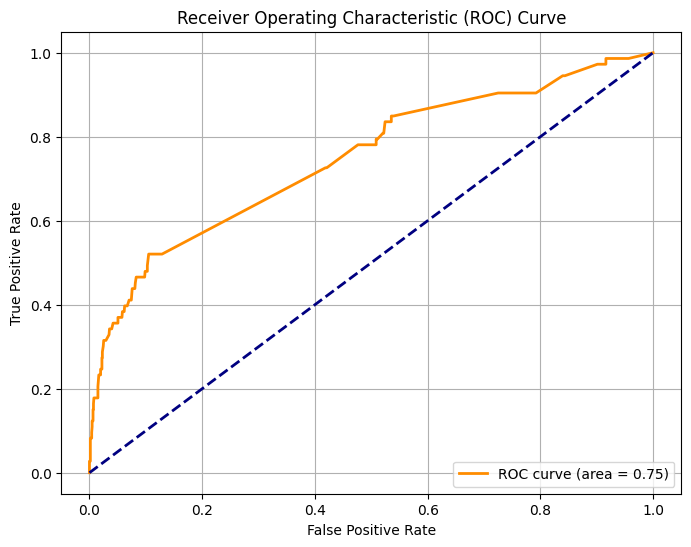

In [ ]:
# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_gb, y_pred_test_prob_gb)
roc_auc = auc(fpr, tpr)

# plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



---



## **Question 2:**

### Which features have the most significant impact on predicting the price of a product, and can we identify a subset of important features using LASSO regression?

###**Linear Regression**

In [ ]:
predictors = ['rating','brand_name','loves_count','reviews','limited_edition','online_only'] # predictor variables
contin = ['rating','loves_count','reviews','limited_edition','online_only'] # continuous variables

X = sephora[predictors]
y = sephora['price_usd']


# train-test-split model validation
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

# z score
z = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), contin),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['brand_name']) # one hot encode brand_name
    ],
    remainder='passthrough'
)

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
r_train = r2_score(y_train,y_pred_train)

mse_test = mean_squared_error(y_test,y_pred_test)
r_test = r2_score(y_test,y_pred_test)

# assess
print("Train MSE : ", mse_train)
print("Train R2  : ", r_train)

print("\nTest MSE  : ", mse_test)
print("Test R2   : ", r_test)

Train MSE :  963.813662763041
Train R2  :  0.5343759874909442

Test MSE  :  1091.4103066890857
Test R2   :  0.5436336478421941


###**LASSO Regression Model**

In [ ]:
# build LASSO model
la = LassoCV()

pipe_la = Pipeline([("zscore", z),
                    ("lasso", la)])

# fit
pipe_la.fit(X_train,y_train)

# predict
y_pred_train_la = pipe_la.predict(X_train)
y_pred_test_la = pipe_la.predict(X_test)

mse_train2 = mean_squared_error(y_train,y_pred_train_la)
r_train2 = r2_score(y_train,y_pred_train_la)

mse_test2 = mean_squared_error(y_test,y_pred_test_la)
r_test2 = r2_score(y_test,y_pred_test_la)

# assess
print("Train MSE : ", mse_train2)
print("Train R2  : ", r_train2)

print("\nTest MSE :  ", mse_test2)
print("Test R2  :  ", r_test2)

Train MSE :  968.1582484510596
Train R2  :  0.532277092757552

Test MSE :   1100.0338263358456
Test R2  :   0.5400277773644893


####**Get the coefficients from LASSO model**

In [ ]:
# get the one hot encoded column names (brand names)
onehot_feature_names = z.named_transformers_['onehot'].get_feature_names_out(['brand_name'])

# create a list of all column names, including the original and the new one hot encoded columns
column_names = list(contin)
column_names.extend(onehot_feature_names)
column_names.extend(X.columns.difference(contin + ['brand_name']))

# get the coefficients
lasso_coefs = pipe_la.named_steps["lasso"].coef_

# create a dataframe with the feature names and coefficients
coef_table = pd.DataFrame({"Feature": column_names, "Coefficient": lasso_coefs})

# print out number of features
coef_table.shape

(287, 2)

####**Bar Chart to Show Top 10 Coefficient Values**

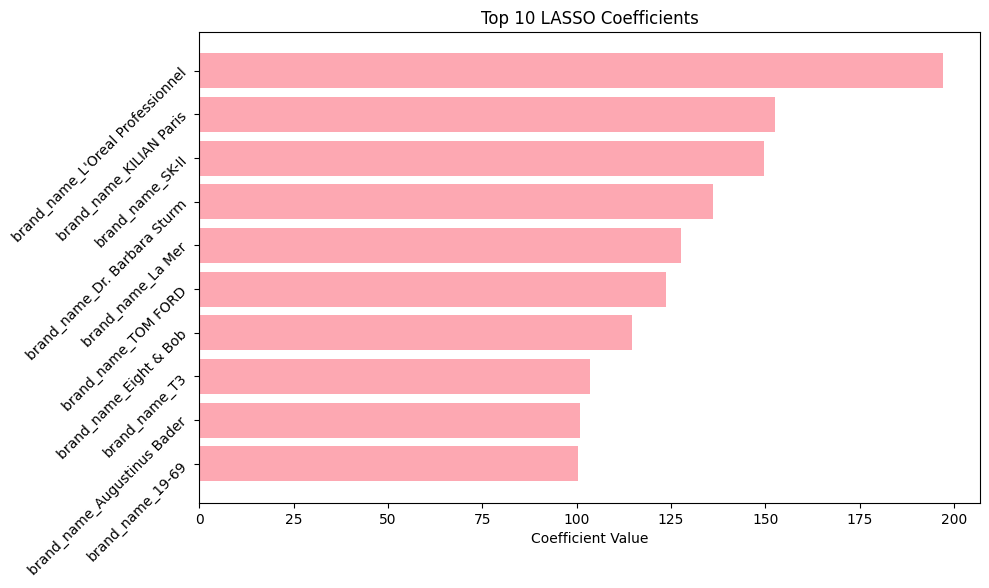

In [ ]:
# sort coefficients based on their absolute values
sorted_indices = np.argsort(np.abs(lasso_coefs))[::-1]

# select the top 10 coefficients
top_n = 10
selected_indices = sorted_indices[:top_n]
selected_variables = [column_names[i] for i in selected_indices]
selected_coefficients = [lasso_coefs[i] for i in selected_indices]

# create a horizontal bar chart displaying top 10 coefficient variables
plt.figure(figsize=(10, 6))
plt.barh(selected_variables[::-1], selected_coefficients[::-1], color=['#fda8b2'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 LASSO Coefficients')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

####**Table of all variables LASSO model 'pulled' to 0**

In [ ]:
# get table with features with a coefficient value equal to 0
zero_coef = coef_table[coef_table['Coefficient'] == 0]
zero_coef

,Feature,Coefficient
25,brand_name_Blinc,-0.0
40,brand_name_COOLA,-0.0
54,brand_name_Crown Affair,0.0
56,brand_name_DAMDAM,0.0
59,brand_name_DOMINIQUE COSMETICS,0.0
60,brand_name_Dame,0.0
93,brand_name_GLO Science,0.0
108,brand_name_Hanni,-0.0
112,brand_name_Hyper Skin,0.0
123,brand_name_Josie Maran,-0.0


Results: 32 variables

####**Comparing R-Squared Values for Linear Regression and LASSO Models**

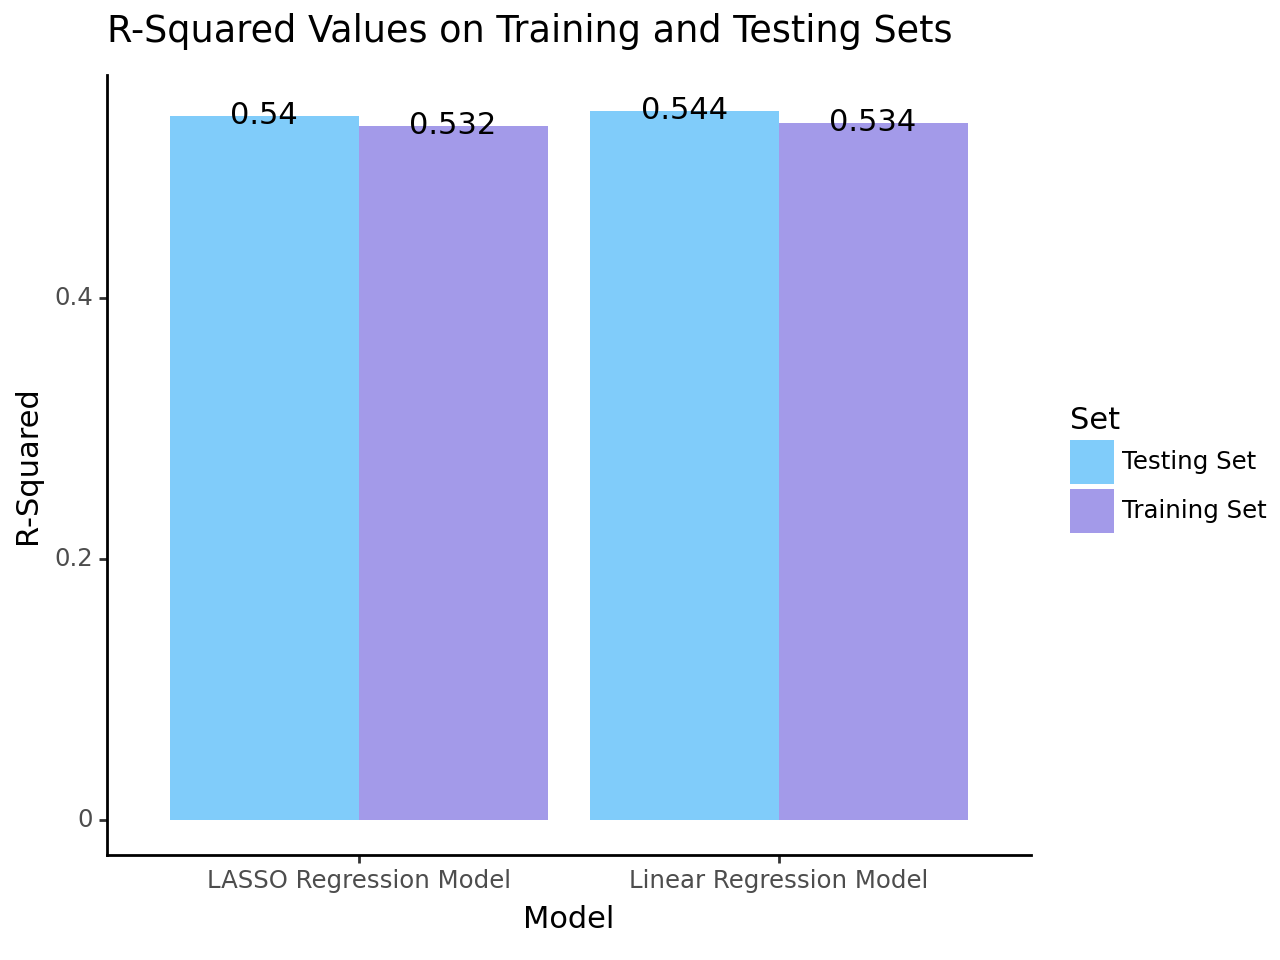

<Figure Size: (640 x 480)>

In [ ]:
# put all of the R-Squared values for each model into a dataframe
r_values = pd.DataFrame({
    'model': ['Linear Regression Model','LASSO Regression Model'],
    'r_train': [r_train, r_train2],
    'r_test': [r_test, r_test2]
})

# melt the dataframe
r_melt = r_values.melt(id_vars='model', var_name='Set', value_name='r_squared')

# plot the graph comparing R-squared values
(ggplot(r_melt, aes(x='model', y='r_squared', fill='Set')) +
        geom_bar(stat='identity', position='dodge') +
        labs(title='R-Squared Values on Training and Testing Sets',
             x='Model',
             y='R-Squared') +
        scale_fill_manual(values=["#80ccfa", "#a39ae9"],
                          labels={'r_train':'Training Set', 'r_test':'Testing Set'}) +
        geom_text(aes(label='round(r_squared,3)'), color='black', position=position_dodge(.9)) +
        theme_classic()
 )

####**Comparing MSE Values for Linear Regression and LASSO Models**

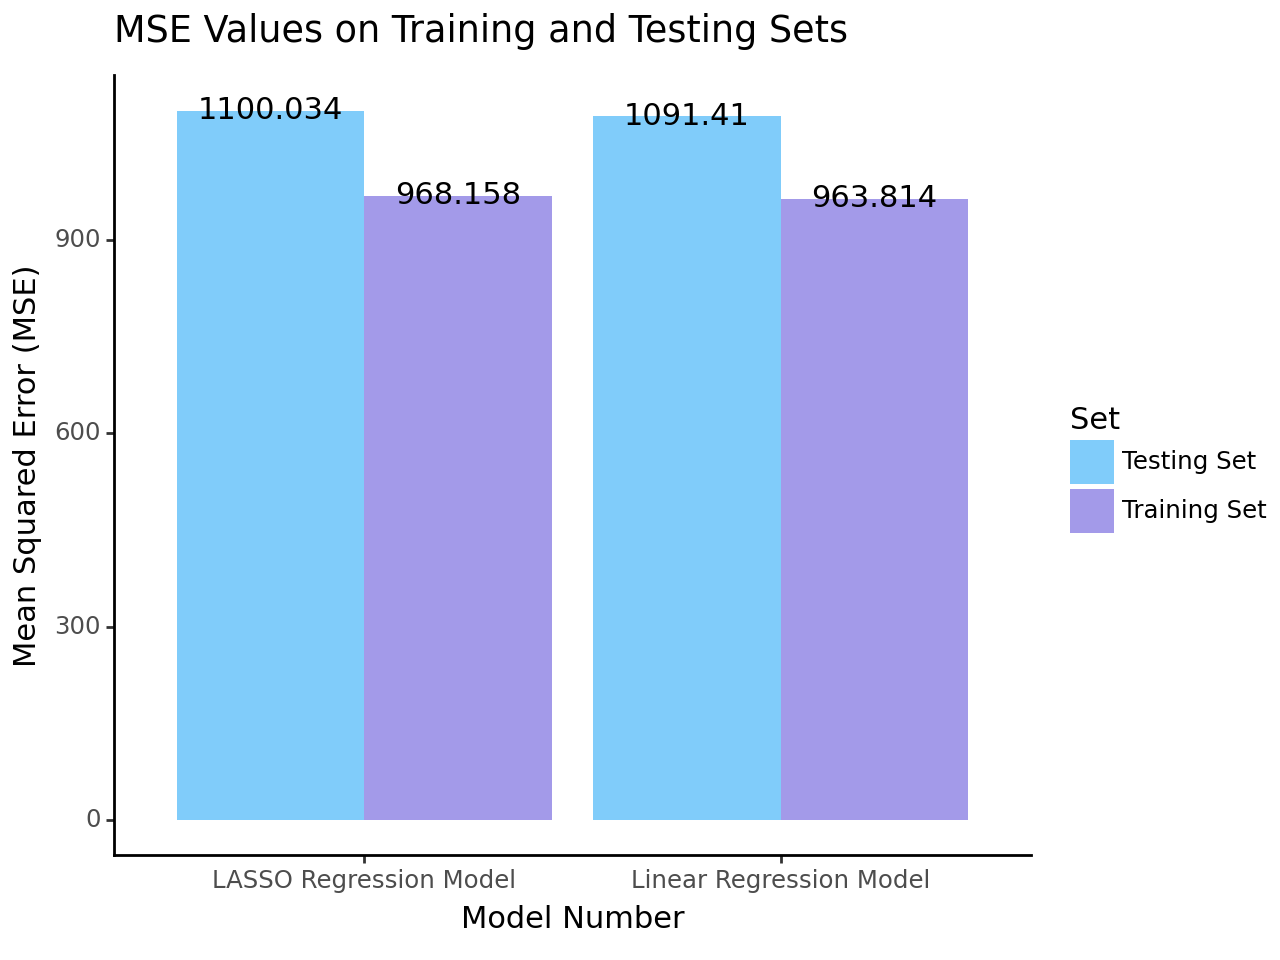

<Figure Size: (640 x 480)>

In [ ]:
# put all of the MSE values for each model into a dataframe
mse_values = pd.DataFrame({
    'model': ['Linear Regression Model','LASSO Regression Model'],
    'mse_train': [mse_train, mse_train2],
    'mse_test': [mse_test, mse_test2]
})

# melt the dataframe
mse_melt = mse_values.melt(id_vars='model', var_name='Set', value_name='mse')

# plot chart comparing MSE values
(ggplot(mse_melt, aes(x='model', y='mse', fill='Set')) +
        geom_bar(stat='identity', position='dodge') +
        labs(title='MSE Values on Training and Testing Sets',
             x='Model Number',
             y='Mean Squared Error (MSE)') +
        scale_fill_manual(values=["#80ccfa", "#a39ae9"],
                          labels={'mse_train':'Training Set', 'mse_test':'Testing Set'}) +
        geom_text(aes(label='round(mse,3)'), color='black', position=position_dodge(.9)) +
        theme_classic()
 )



---

## **Question 3:**

### When considering rating, size, and price, what clusters emerge, and what kind of products are in those clusters?

####**Data Cleaning: Extract 'oz' number from size column**

In [ ]:
# extract the first numeric value from the 'size' column for products measured in oz
sephora['extracted_size'] = sephora['size'].str.extract('(\d+\.\d+|\d+)\s*oz')

# convert the extracted values to numeric type
sephora['extracted_size'] = pd.to_numeric(sephora['extracted_size'], errors='coerce')

# drop any rows that aren't in oz
sephora = sephora.dropna(subset=['extracted_size'])

# show last 5 rows
sephora.tail()

,index,brand_name,loves_count,rating,reviews,size,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,extracted_size
6690,8483,Yves Saint Laurent,3812,5.0000,6.0,3.3 oz/ 100 mL,148.0,0,0,0,0,0,3.30
6691,8484,Yves Saint Laurent,3489,4.0192,104.0,0.25 oz/ 7.5 ml,29.0,0,0,0,0,0,0.25
6692,8485,Yves Saint Laurent,3240,4.2857,21.0,2.6 oz,24.0,0,0,0,1,0,2.60
6693,8486,Yves Saint Laurent,3089,4.7333,150.0,3.4 oz/ 100 mL,99.0,0,0,0,1,0,3.40
6694,8490,Yves Saint Laurent,2319,4.6367,556.0,2 oz / 60 mL,106.0,0,0,0,0,0,2.00


####**Scatterplots of Pairs of Each Variable Combination**

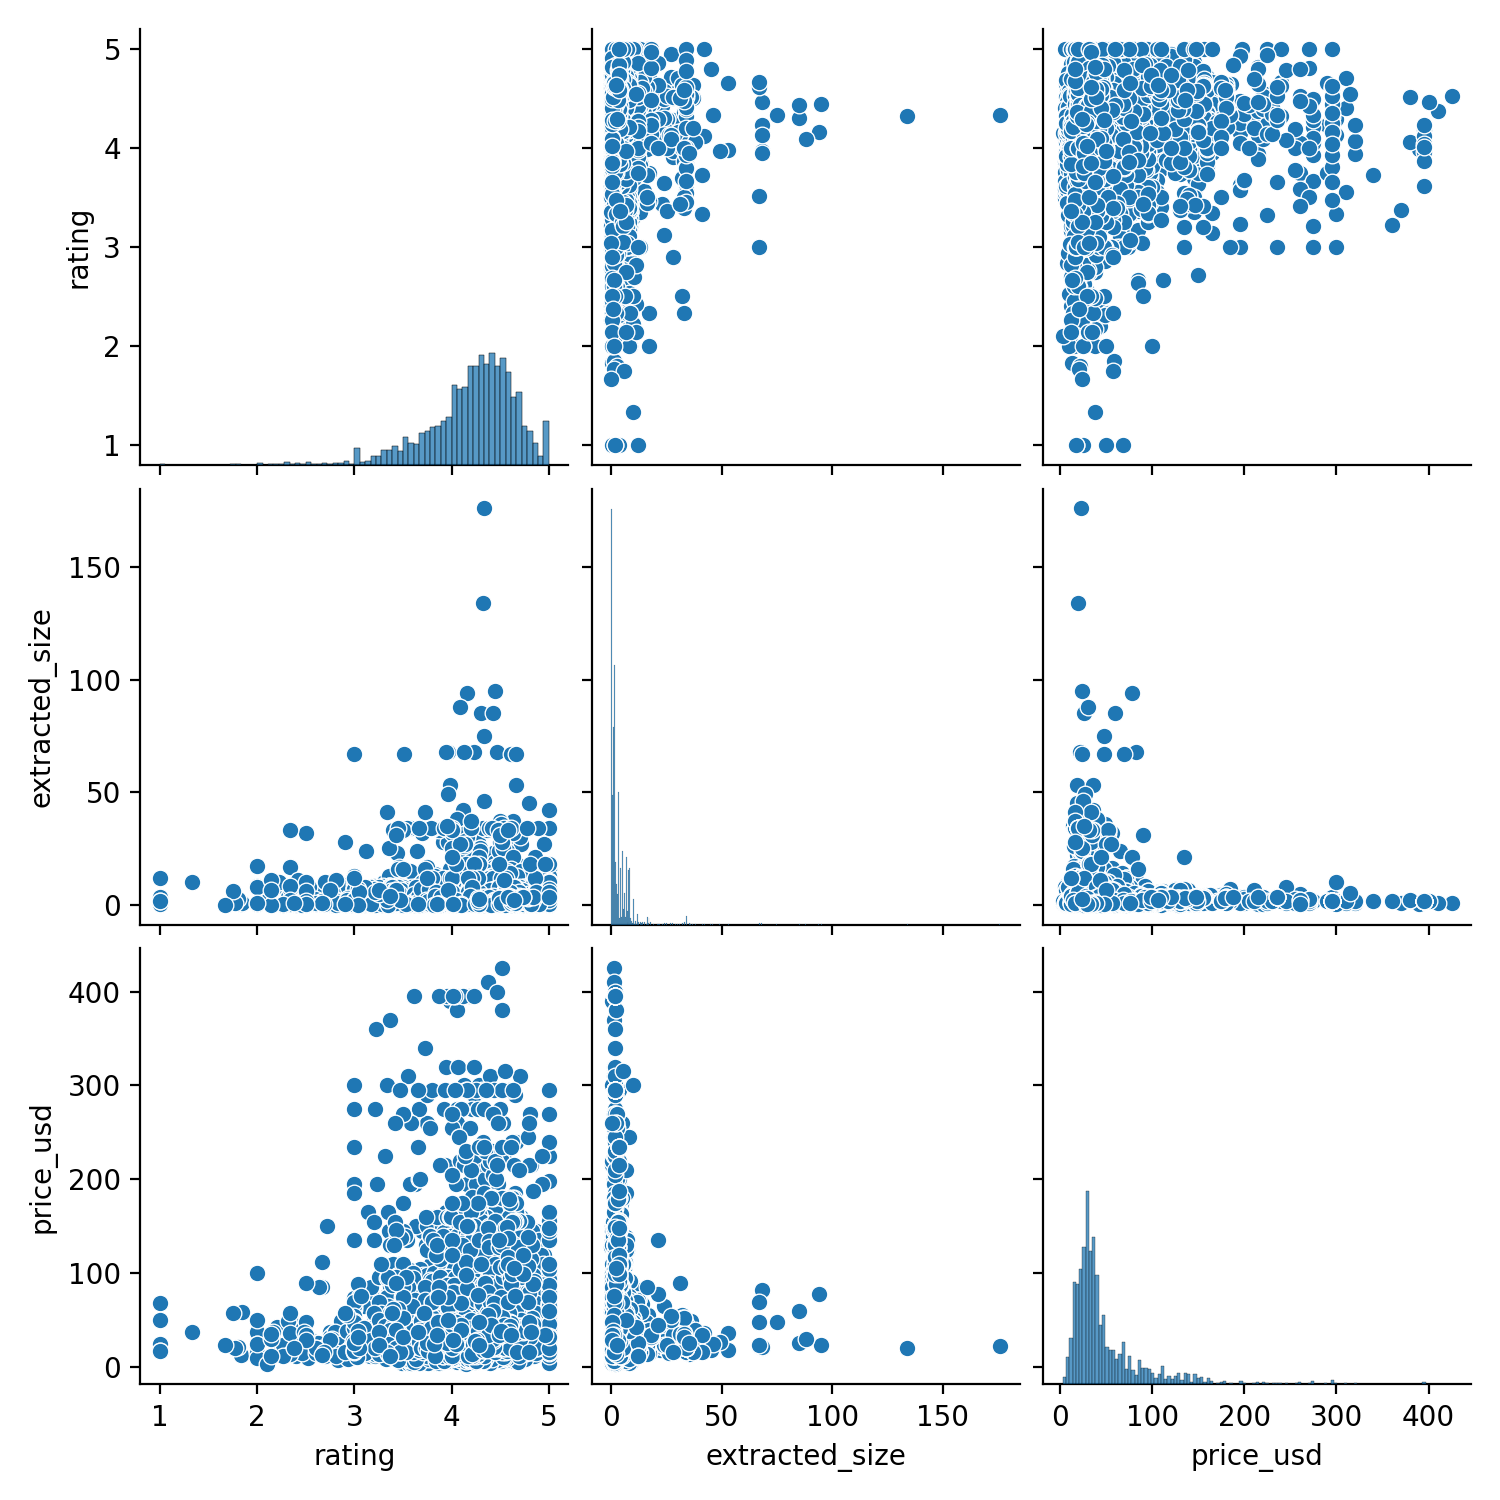

In [ ]:
# plots every combination of each variable
sns.pairplot(sephora[['rating','extracted_size','price_usd']])
plt.show()

###**K-Means Clustering Model**

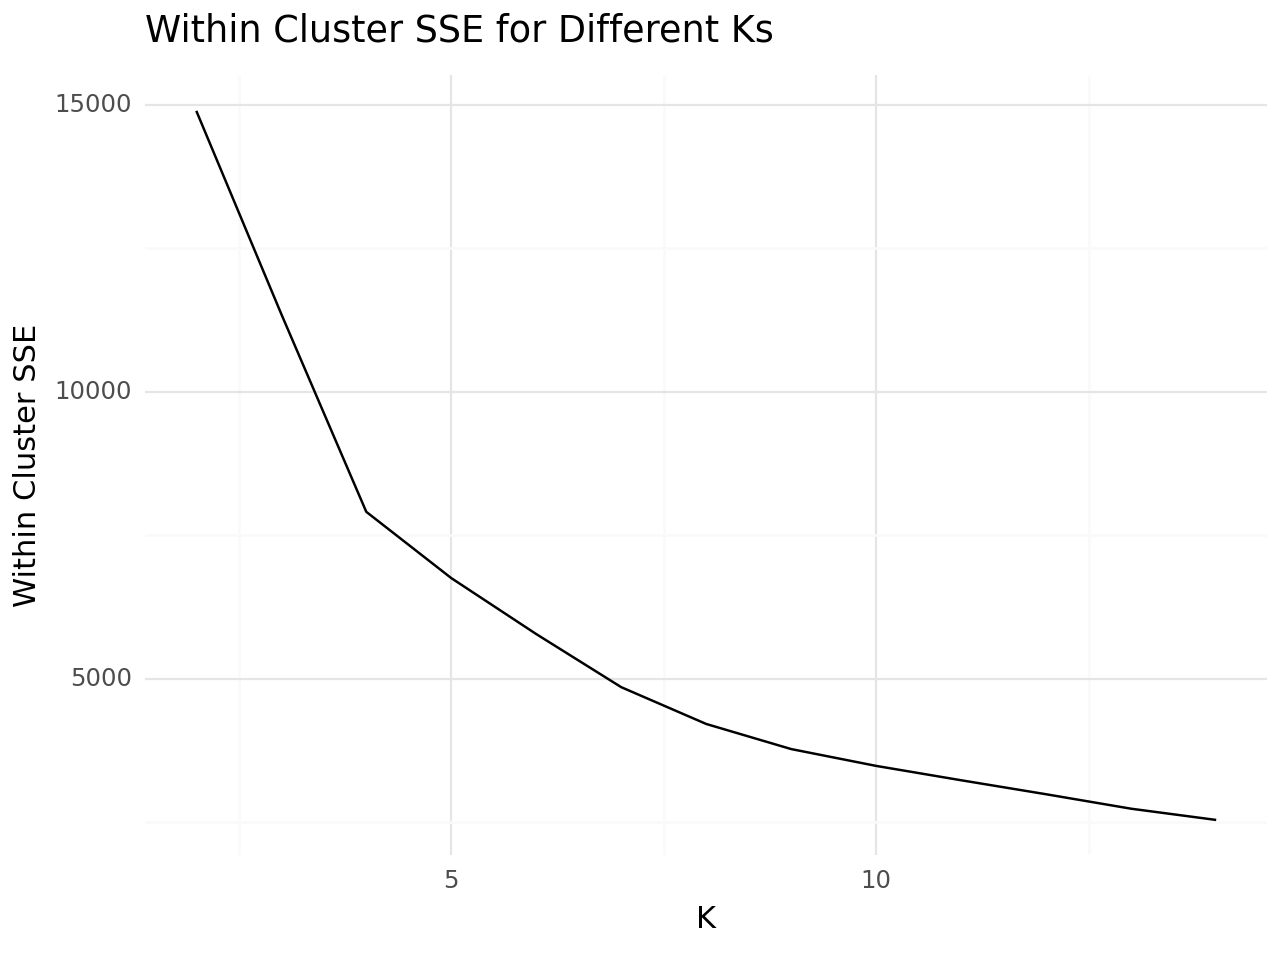

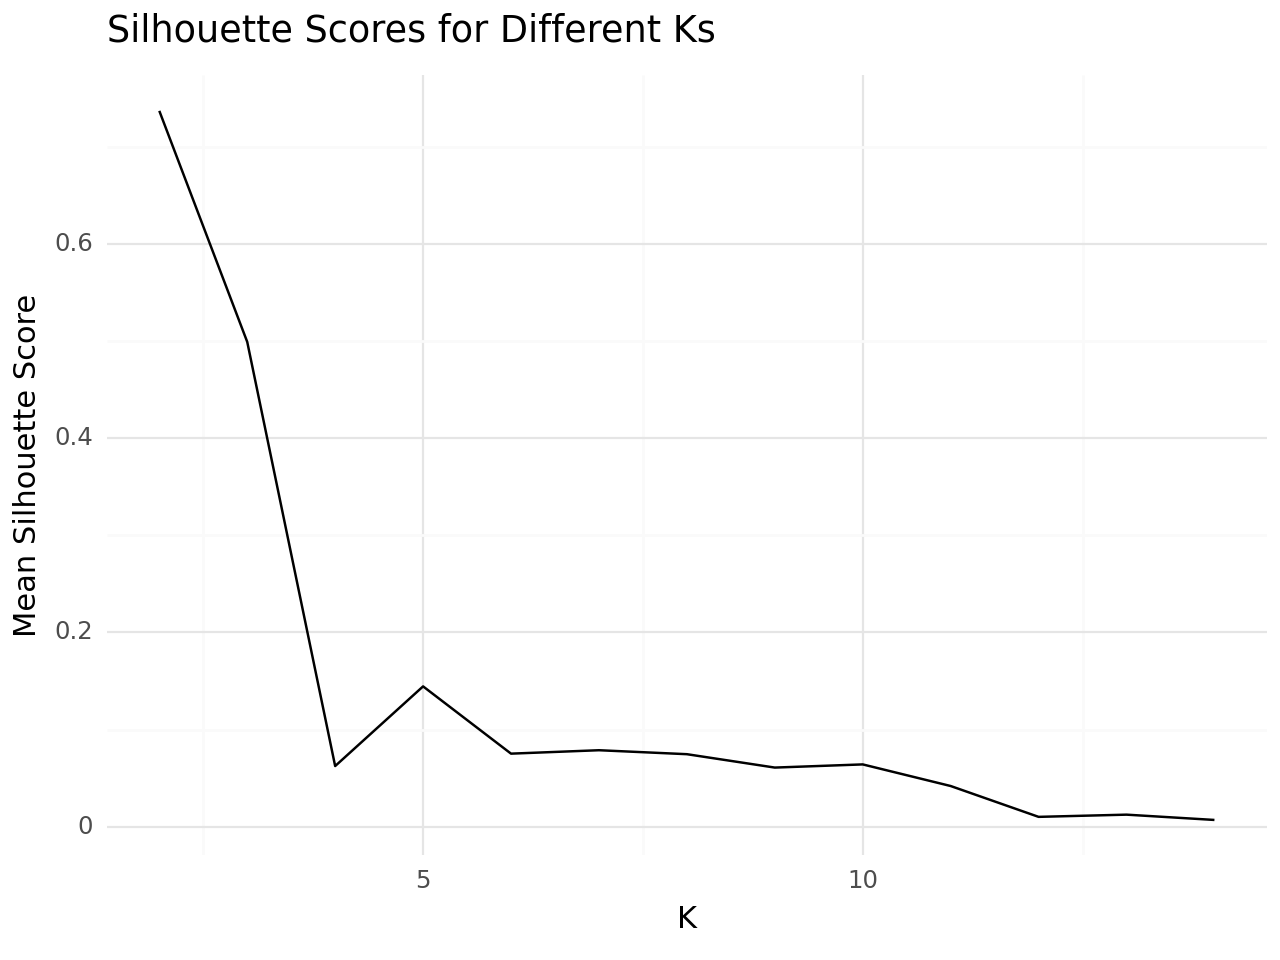


The value of k with the highest silhouette score is: 2


In [ ]:
feats = ['rating','price_usd','extracted_size'] # feature variables

X = sephora[feats]

# z-score
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

# dictionary of metrics
metrics = {"SSE": [], "sil": [], "k": []}

# calculate SSE and Silhouette score for 2 to 15 clusters
for i in range(2,15):
    km = KMeans(i)
    pipe = Pipeline([
        ("pre", z),
        ("km", km)
    ])

    labels = pipe.fit_predict(X[feats])
    sil = silhouette_score(X[feats], labels)
    sse = pipe.named_steps["km"].inertia_

    metrics["SSE"].append(sse)
    metrics["sil"].append(sil)
    metrics["k"].append(i)

# create a new dataframe with the metrics
df = pd.DataFrame(metrics)

# find the index where the maximum silhouette score occurs
max_sil = df['sil'].idxmax()

# get the coordinating k value with max score
max_sil_k = df.loc[max_sil, 'k']

# within clusters sse plot
# look at the elbow to find which k is the best
print(ggplot(df, aes(x = "k", y = "SSE")) +
      geom_line() + theme_minimal() +
      labs(x = "K", y = "Within Cluster SSE",
           title = "Within Cluster SSE for Different Ks") +
      theme_minimal())

# silhouette scores plot
# choose the highest silhouette score
print(ggplot(df, aes(x = "k", y = "sil")) +
      geom_line() + theme_minimal() +
      labs(x = "K", y = "Mean Silhouette Score",
           title = "Silhouette Scores for Different Ks") +
      theme_minimal())

print(f"The value of k with the highest silhouette score is: {max_sil_k}")

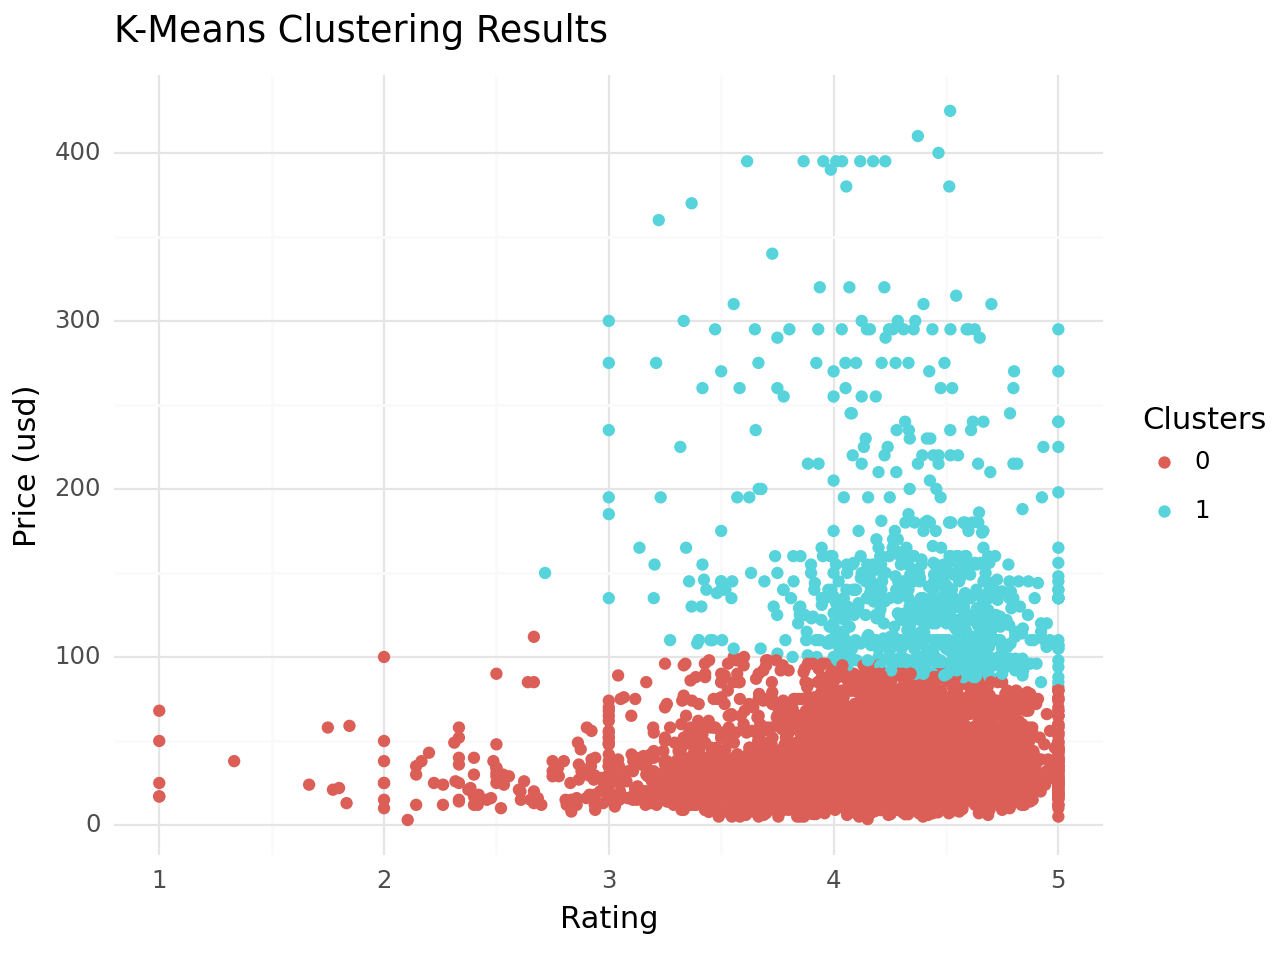

In [ ]:
# create K-means clustering model with 2 clusters
km = KMeans(2)

pipe = Pipeline([("z", z), ("km", km)])

labels = pipe.fit_predict(X)

X["clusters"] = labels

# plot model on rating vs. price to show clusters
print(ggplot(X, aes(x = "rating", y = "price_usd", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
      labs(x = "Rating", y = "Price (usd)", title = "K-Means Clustering Results",
           color = "Clusters"))

####Print Silhouette Score

In [ ]:
print('Silhouette Score: ', silhouette_score(X, labels))

Silhouette Score:  0.7371170624330498


###**Gaussian Mixture Model**

Do a GMM to see if we can do better than K-means

The value of k with the lowest BIC is: 12


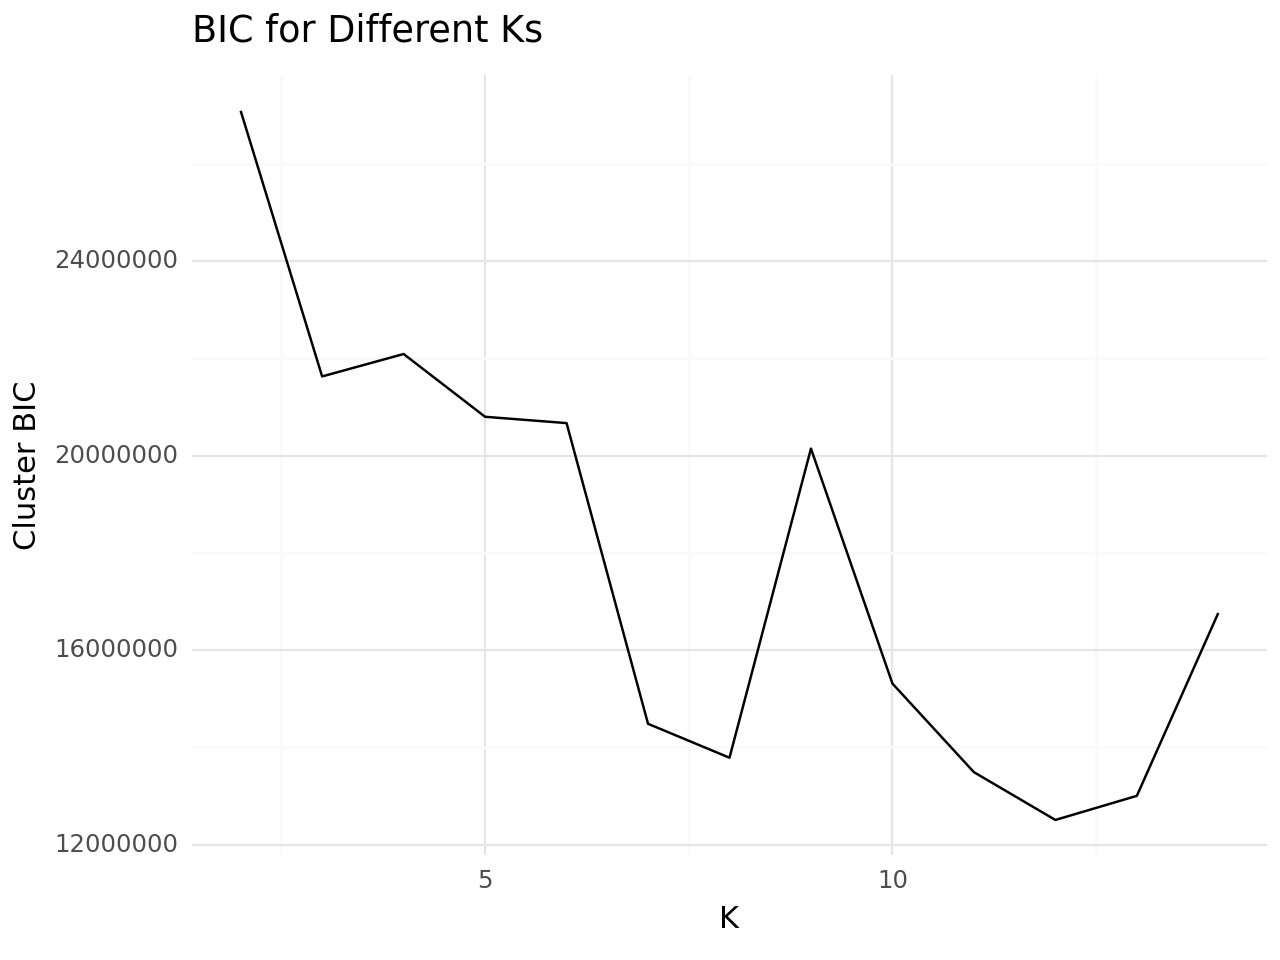

In [ ]:
feats_gmm = ['rating','price_usd','extracted_size'] # feature variables

X_gmm = sephora[feats_gmm]

# z-score
z_gmm = make_column_transformer((StandardScaler(), feats_gmm),
                                remainder = "passthrough")

# dictionary with metrics
metrics_gmm = {"BIC": [], "k": []}

# for 2-15 clusters, calculate BIC value
for i in range(2,15):
    gmm = GaussianMixture(i)
    pipe_gmm = Pipeline([
        ("pre", z_gmm),
        ("gmm", gmm)
    ])

    labels_gmm = pipe_gmm.fit_predict(X_gmm[feats_gmm])
    bic_val = pipe_gmm.named_steps["gmm"].bic(X_gmm[feats_gmm])

    metrics_gmm["BIC"].append(bic_val)
    metrics_gmm["k"].append(i)

# create a new dataframe with metrics
df_gmm = pd.DataFrame(metrics_gmm)

# find the index where the minimum BIC occurs
min_bic_index = df_gmm['BIC'].idxmin()

# get corresponding k value for lowest BIC value
min_bic_k = df_gmm.loc[min_bic_index, 'k']

# print out k for lowest BIC
print(f"The value of k with the lowest BIC is: {min_bic_k}")

# plot the BIC for different Ks
print(ggplot(df_gmm, aes(x = "k", y = "BIC")) +
      geom_line() + theme_minimal() +
      labs(x = "K", y = "Cluster BIC",
          title = "BIC for Different Ks"))

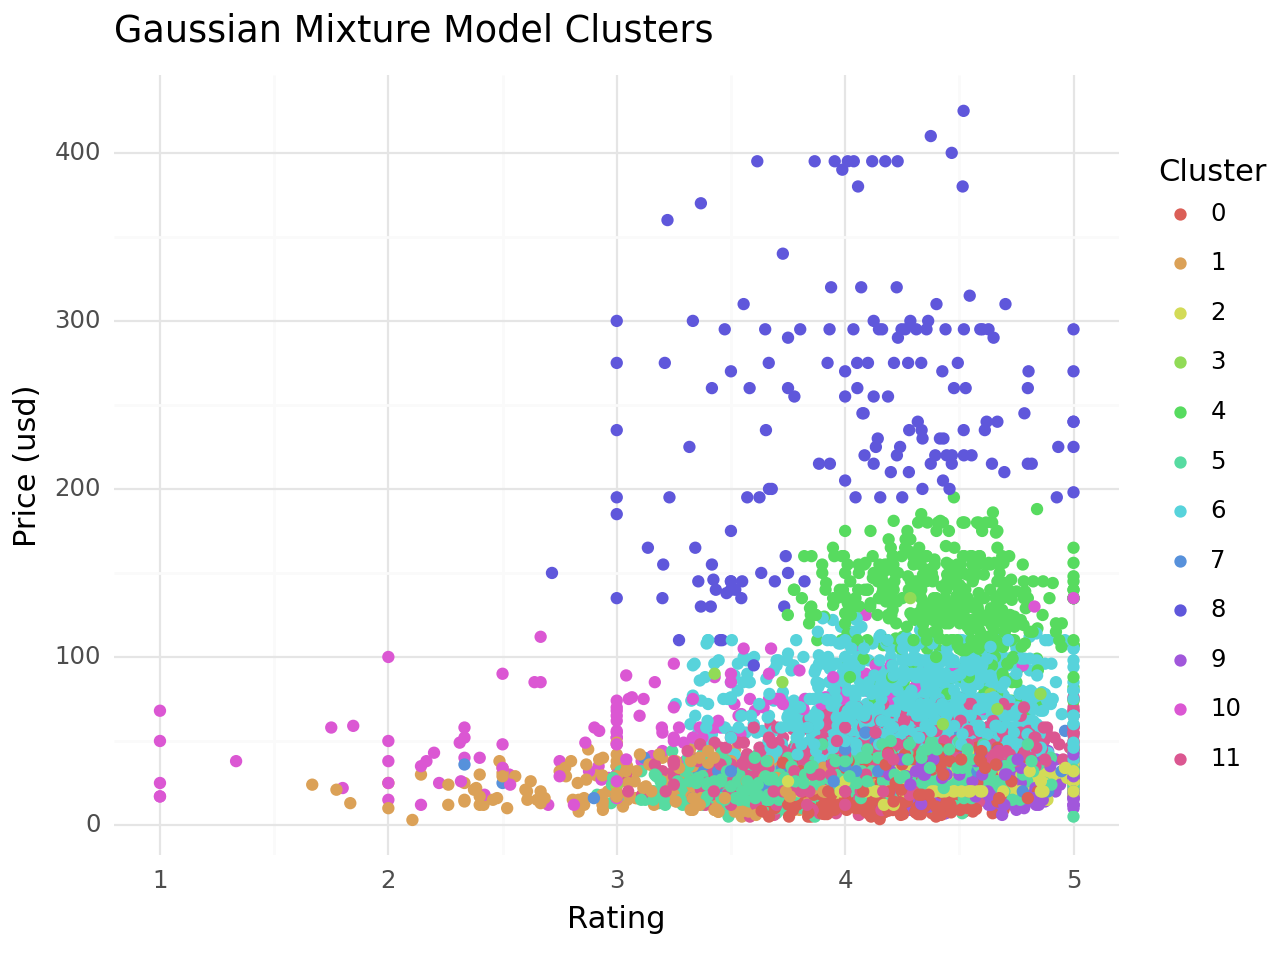

In [ ]:
# create a GMM model with 12 clusters
gmm = GaussianMixture(12)

pipe_gmm = Pipeline([
      ("pre", z_gmm),
      ("gmm", gmm)
])

# predict
labels_gmm = pipe_gmm.fit_predict(X_gmm[feats_gmm])

# get the clusters
X_gmm["cluster"] = labels_gmm

# plot the GMM on rating vs. price to show clusters
print(ggplot(X_gmm, aes(x = "rating", y = "price_usd", color = "factor(cluster)")) +
      geom_point() +
      theme_minimal() +
      scale_color_discrete(name = "Cluster") +
      labs(x = "Rating",
           y = "Price (usd)",
           title = "Gaussian Mixture Model Clusters"))

#####Print BIC Value and Silhouette Score

In [ ]:
print('BIC Value: ', pipe_gmm.named_steps["gmm"].bic(X_gmm[feats_gmm]))
print('Silhouette Score: ', silhouette_score(X_gmm, labels_gmm))

BIC Value:  20066478.801036827
Silhouette Score:  0.06955589487219568


Note: The GMM model performed worse than K-Means so we will disregard

####**Cluster Summary for K-Means Model**

In [ ]:
# get the average values for each feature in each cluster
cluster_summary = X.groupby('clusters').mean().reset_index()

# format to make it look pretty
print(tabulate(cluster_summary, headers='keys', tablefmt='pretty'))

+---+----------+-------------------+-------------------+--------------------+
|   | clusters |      rating       |     price_usd     |   extracted_size   |
+---+----------+-------------------+-------------------+--------------------+
| 0 |   0.0    | 4.186374684457266 | 36.66747024882799 | 3.758322376487559  |
| 1 |   1.0    | 4.347482264150943 | 148.5937106918239 | 2.3717962264150945 |
+---+----------+-------------------+-------------------+--------------------+
